In [12]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [14]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from IPython.display import clear_output

In [17]:
from keras import layers, models

from keras_tuner.tuners import RandomSearch
from keras.callbacks import ModelCheckpoint

## Loading and Preparing Data

In [18]:
def load_images(images_paths, labels_paths, valid_labels):
    images = []
    labels = []

    no_label_counter = 0
    unidentified_counter = 0

    for images_path, labels_path in zip(images_paths, labels_paths):

        # Load labels from csv file
        labels_df = pd.read_csv(labels_path, sep=';')
        labels_df['Filename'] = [file[:-3] + 'png' for file in labels_df['Filename']]

        for filename in os.listdir(images_path):
            # Load the image using PIL
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path)

            # Crop the image to the size of the spectrogram
            left, upper, right, lower = 55, 36, 389, 252
            img = img.crop((left, upper, right, lower))

            # Convert image to numpy array and normalize
            img_array = np.array(img)[:, :, :3] / 255.0

            # Extract class label from the CSV file based on the image filename
            label_row = labels_df.loc[labels_df['Filename'] == filename]
            
            if label_row.empty:
                no_label_counter += 1
                continue

            label = label_row['Species'].values[0]

            if label not in valid_labels:
                unidentified_counter += 1
                continue
                
            labels.append(label)
            images.append(img_array)
                

    if no_label_counter:
        print(f'Label not found for {no_label_counter} images : Images will not be used.')
    if unidentified_counter:
        print(f'Bat unidentified for {unidentified_counter} images : Images will not be used.')

    return np.array(images), np.array(labels)

In [19]:
images_folders = ['./Data/dataset1', './Data/dataset2', './Data/dataset3']
labels_paths = ['./Data/dataset1_classified.csv', './Data/dataset2_classified.csv', './Data/dataset3_classified.csv']

In [20]:
# Extract the valid labels
valid_labels = set()
for labels_path in labels_paths:
    labels_df = pd.read_csv(labels_path, sep=';')
    valid_labels = valid_labels.union(set(labels_df['Species'].values))

print(f'Valid labels: {valid_labels}')

Valid labels: {'Bechsteinfledermaus', 'Schwarzbild', 'Mausohr', 'Fransenfledermaus', 'Große Hufeisennase', '&Mausohr ', 'Fledermaus nicht bestimmbar', 'Langohrfledermaus', 'Bartfledermaus', 'Wimperfledermaus', 'Hufeisennase', 'Wasserfledermaus'}


In [21]:
# Remove invalid labels if they exist
invalid_labels = ['Fledermaus nicht bestimmbar', 'Schwarzbild', 'Wimperfledermaus'] # Wimperfledermaus has to be excluded due to lack of data
valid_labels = [label for label in valid_labels if label not in invalid_labels]

# Remove non-alphabetical labels
valid_labels = [label for label in valid_labels if label.isalpha()]

print(f'Valid labels: {valid_labels}')
print(f'Number of valid labels: {len(valid_labels)}')

Valid labels: ['Bechsteinfledermaus', 'Mausohr', 'Fransenfledermaus', 'Langohrfledermaus', 'Bartfledermaus', 'Hufeisennase', 'Wasserfledermaus']
Number of valid labels: 7


In [22]:
images, labels = load_images(images_folders, labels_paths, valid_labels)
print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

Label not found for 10 images : Images will not be used.
Bat unidentified for 340 images : Images will not be used.
Images shape:  (3768, 216, 334, 3)
Labels shape:  (3768,)


In [23]:
# Converting to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

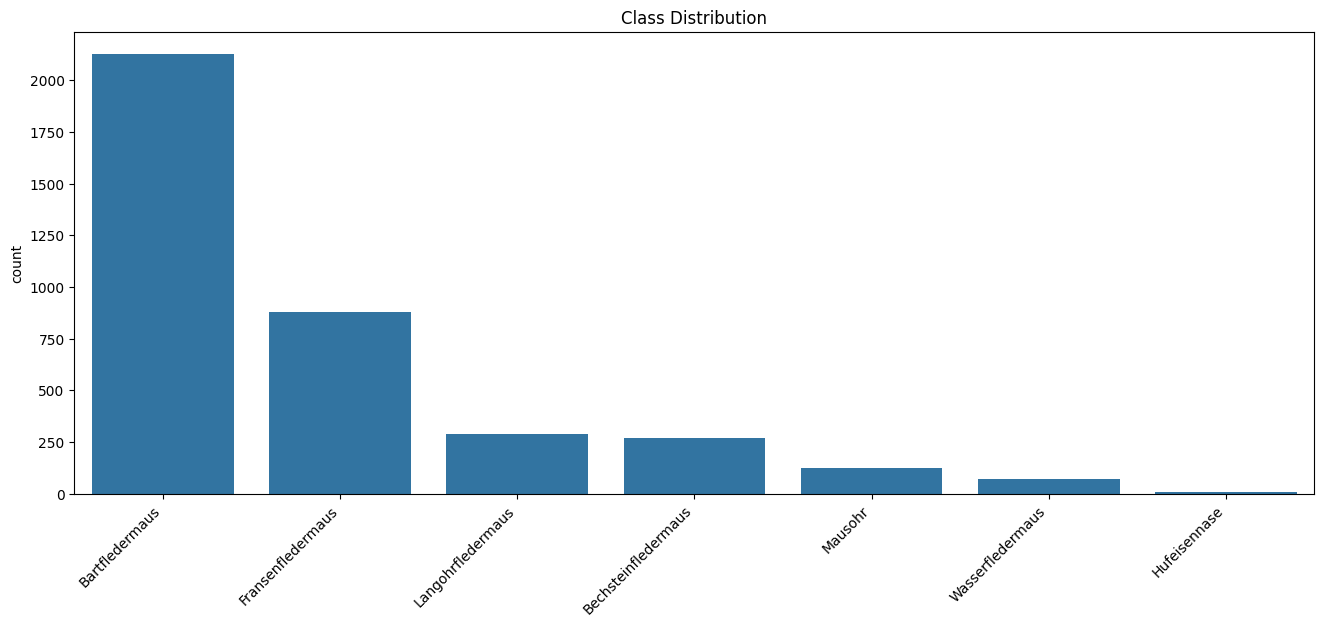

Bartfledermaus         2129
Fransenfledermaus       878
Langohrfledermaus       290
Bechsteinfledermaus     271
Mausohr                 123
Wasserfledermaus         70
Hufeisennase              7
Name: count, dtype: int64


In [24]:
label_counts = pd.Series(labels).value_counts()

plt.figure(figsize=(16, 6))
sns.countplot(x=labels, order=label_counts.index)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

print(label_counts)

In [13]:
# Flatten the images
images_flattened = images.reshape(images.shape[0], -1)

# Split the data for FFNN
X_train_FFNN, X_test_FFNN, y_train_FFNN, y_test_FFNN = train_test_split(images_flattened, encoded_labels, test_size=0.3, random_state=42)
X_train_FFNN, X_val_FFNN, y_train_FFNN, y_val_FFNN = train_test_split(X_train_FFNN, y_train_FFNN, test_size=0.2, random_state=42)

# Split the data for CNN
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_CNN, y_train_CNN, test_size=0.2, random_state=42)

In [14]:
# One-hot encode the labels for FFNN
y_train_FFNN = to_categorical(y_train_FFNN)
y_val_FFNN = to_categorical(y_val_FFNN)
y_test_FFNN = to_categorical(y_test_FFNN)

In [15]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(encoded_labels),
                                                  y=encoded_labels)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Inverse transform the encoded labels to get the original classes
original_classes = label_encoder.inverse_transform(np.unique(encoded_labels))

for c, weight in class_weights_dict.items():
    original_class = original_classes[c]
    print(f'{original_class}: {weight}')

Bartfledermaus: 0.2528349996644971
Bechsteinfledermaus: 1.9862941486557724
Fransenfledermaus: 0.6130816791409046
Hufeisennase: 76.89795918367346
Langohrfledermaus: 1.8561576354679803
Mausohr: 4.376306620209059
Wasserfledermaus: 7.689795918367347


## FFNN

In [16]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define plot callback
class PlotInfo(keras.callbacks.Callback):
    def __init__(self):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.best_val_loss = float('inf')
        self.best_val_loss_epoch = 1
        self.best_val_accuracy = 0
        self.best_val_accuracy_epoch = 1

        self.epoch = 1
        self.logs = []

    def on_epoch_end(self, epoch, logs=None):
        self.logs.append(logs)
        self.x.append(self.epoch)

        self.losses.append(logs.get('loss', 0))
        self.val_losses.append(logs.get('val_loss', 0))
        self.accuracy.append(logs.get('accuracy', 0))
        self.val_accuracy.append(logs.get('val_accuracy', 0))

        # Check if current val_loss is the best so far
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            self.best_val_loss_epoch = self.epoch

        # Check if current val_accuracy is the best so far
        if logs.get('val_accuracy') > self.best_val_accuracy:
            self.best_val_accuracy = logs.get('val_accuracy')
            self.best_val_accuracy_epoch = self.epoch

        self.epoch += 1
        clear_output(wait=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Subplot for loss
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.scatter(self.best_val_loss_epoch, self.best_val_loss, marker='o', color='red', label=f'best val_loss ({self.best_val_loss:.3f})')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.legend()

        # Subplot for accuracy
        ax2.plot(self.x, self.accuracy, label="accuracy")
        ax2.plot(self.x, self.val_accuracy, label="val_accuracy")
        ax2.scatter(self.best_val_accuracy_epoch, self.best_val_accuracy, marker='o', color='green', label=f'best val_accuracy ({self.best_val_accuracy:.3f})')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.suptitle(f'Epoch {self.epoch - 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

plot_info_FFNN = PlotInfo()

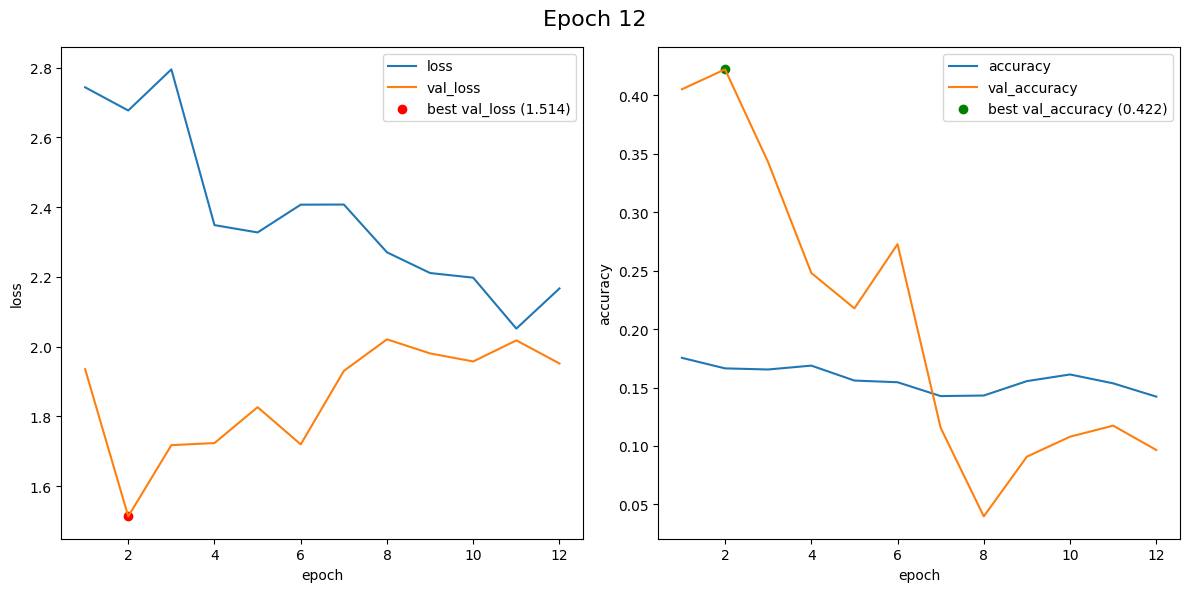

66/66 [==============================] - 12s 183ms/step - loss: 2.1669 - accuracy: 0.1422 - val_loss: 1.9517 - val_accuracy: 0.0966


In [17]:
FFNN_model = Sequential()

FFNN_model.add(Dense(128, input_dim=X_train_FFNN.shape[1], activation='relu'))
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(64, activation='relu'))
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(32, activation='relu'))
FFNN_model.add(BatchNormalization())
FFNN_model.add(Dropout(0.5))

FFNN_model.add(Dense(y_train_FFNN.shape[1], activation='softmax'))

FFNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_FFNN = FFNN_model.fit(X_train_FFNN, y_train_FFNN,
                              epochs=50, batch_size=32,
                              validation_data=(X_val_FFNN, y_val_FFNN),
                              class_weight=class_weights_dict,
                              callbacks=[early_stopping, plot_info_FFNN])

In [18]:
FFNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               27703424  
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [19]:
# Evaluate the model on the test set
y_pred_FFNN = FFNN_model.predict(X_test_FFNN)
loss, accuracy = FFNN_model.evaluate(X_test_FFNN, y_test_FFNN)

36/36 [==============================] - 0s 12ms/step - loss: 1.5705 - accuracy: 0.4094


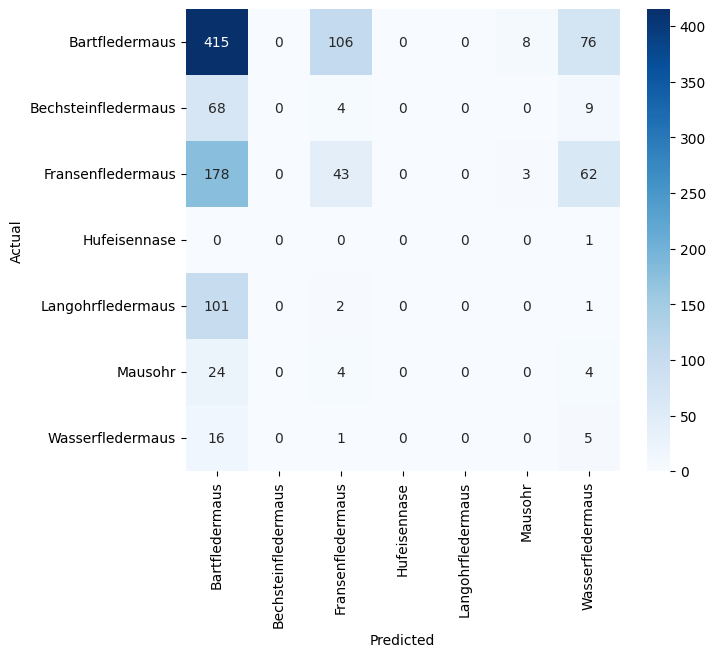

In [20]:
# Convert one-hot encoded y_test_FFNN and y_pred_FFNN back to label encoded form
y_test_FFNN_label_encoded = np.argmax(y_test_FFNN, axis=1)
y_pred_FFNN_label_encoded = np.argmax(y_pred_FFNN, axis=1)

# Extract unique classes present in the test dataset
unique_classes_test_FFNN = np.unique(y_test_FFNN_label_encoded)

# Convert encoded labels back to original classes
target_classes_FFNN = label_encoder.inverse_transform(unique_classes_test_FFNN)

# Generate confusion matrix
confusion_m_FFNN = confusion_matrix(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_FFNN, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes_FFNN, yticklabels=target_classes_FFNN)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
# Classification Report
report_FFNN = classification_report(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded, target_names=target_classes_FFNN, zero_division=1, output_dict=True)
print(classification_report(y_test_FFNN_label_encoded, y_pred_FFNN_label_encoded, target_names=target_classes_FFNN, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.52      0.69      0.59       605
Bechsteinfledermaus       1.00      0.00      0.00        81
  Fransenfledermaus       0.27      0.15      0.19       286
       Hufeisennase       1.00      0.00      0.00         1
  Langohrfledermaus       1.00      0.00      0.00       104
            Mausohr       0.00      0.00      1.00        32
   Wasserfledermaus       0.03      0.23      0.06        22

           accuracy                           0.41      1131
          macro avg       0.55      0.15      0.26      1131
       weighted avg       0.51      0.41      0.39      1131



## CNN

In [17]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    width_shift_range = 0.025,
    height_shift_range = 0.015,
    channel_shift_range= 0.2
)

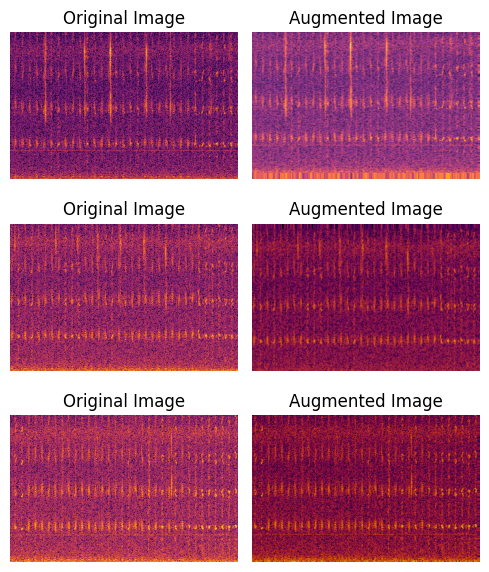

In [18]:
# Generate augmented images
augmented_images = datagen.flow(X_train_CNN, batch_size=1, shuffle=False)

# Plot original and augmented images
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(5, 6))

for i in range(num_samples):
    # Original Image
    original_image = X_train_CNN[i]
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Augmented Image
    augmented_image = augmented_images.next()[0]
    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title('Augmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
CNN_model = models.Sequential()

CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(216, 334, 3)))
CNN_model.add(layers.Dropout(0.1))
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.Dropout(0.1))
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
CNN_model.add(layers.Dropout(0.1))
CNN_model.add(layers.MaxPooling2D((2, 2)))

CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(256, activation='relu'))
CNN_model.add(layers.Dropout(0.3))

CNN_model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

CNN_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Define low accuracy callback
class LowAccuracy(keras.callbacks.Callback):
    def __init__(self, threshold, patience):
        super(LowAccuracy, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)
        if val_accuracy < self.threshold:
            self.counter += 1
        if self.counter >= self.patience:
            self.counter = 0
            self.model.stop_training = True

low_accuracy = LowAccuracy(threshold=0.02, patience=5)


# Define model checkpoint callback
checkpoint_path = './cnn-model/model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Define a new plot callback
plot_info_CNN = PlotInfo()

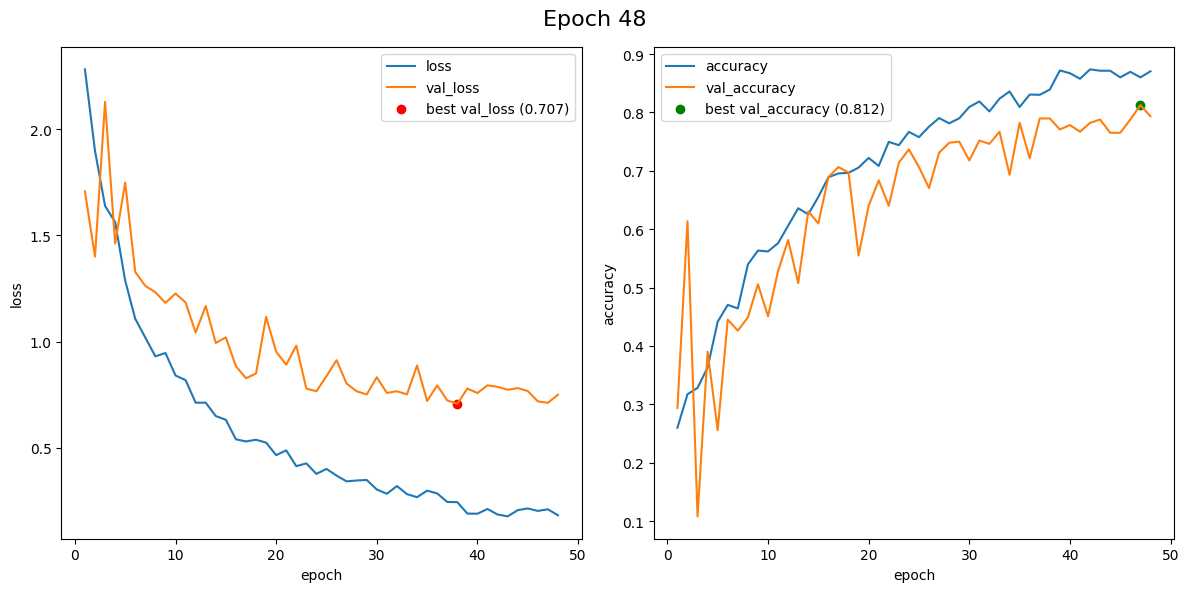

66/66 [==============================] - 248s 4s/step - loss: 0.1818 - accuracy: 0.8706 - val_loss: 0.7494 - val_accuracy: 0.7936


In [21]:
history_CNN = CNN_model.fit(datagen.flow(X_train_CNN, y_train_CNN, batch_size=32),
                            epochs=50,
                            class_weight=class_weights_dict,
                            validation_data=datagen.flow(X_val_CNN, y_val_CNN, batch_size=32),
                            callbacks=[early_stopping, model_checkpoint, plot_info_CNN])

In [22]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 332, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 214, 332, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 166, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 164, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 105, 164, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 82, 128)       0         
 g2D)                                                   

In [23]:
# Evaluate the best model on the test set
y_pred_CNN = CNN_model.predict(X_test_CNN)
test_loss, test_acc = CNN_model.evaluate(X_test_CNN, y_test_CNN)

36/36 [==============================] - 13s 360ms/step - loss: 0.7600 - accuracy: 0.7922


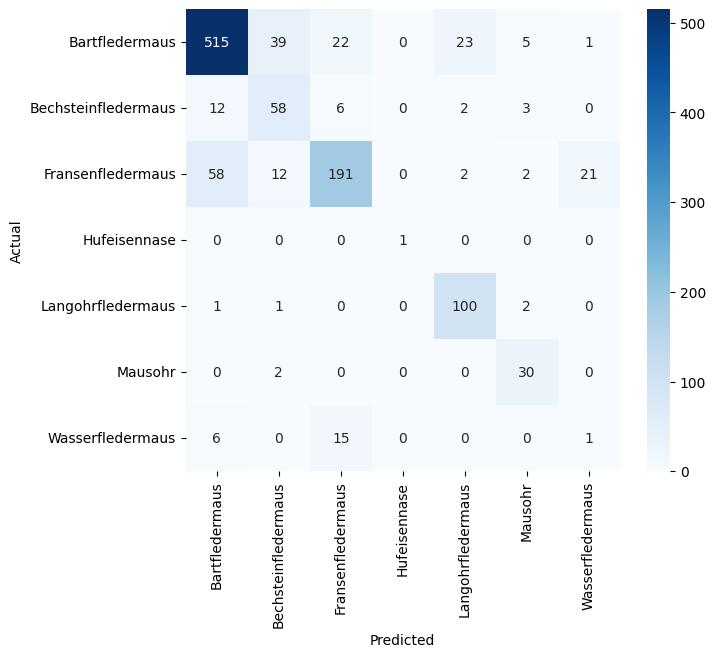

In [24]:
# Convert one-hot encoded y_pred_CNN back to label encoded form
y_pred_CNN_label_encoded = np.argmax(y_pred_CNN, axis=1)

# Extract unique classes present in the test dataset
unique_classes_test_CNN = np.unique(y_test_CNN)

# Convert encoded labels back to original classes
target_classes_CNN = label_encoder.inverse_transform(unique_classes_test_CNN)

# Generate confusion matrix
confusion_m_CNN = confusion_matrix(y_test_CNN, y_pred_CNN_label_encoded)

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_m_CNN, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes_CNN, yticklabels=target_classes_CNN)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# Classification Report
report_CNN = classification_report(y_test_CNN, y_pred_CNN_label_encoded, target_names=target_classes_CNN, zero_division=1, output_dict=True)
print(classification_report(y_test_CNN, y_pred_CNN_label_encoded, target_names=target_classes_CNN, zero_division=1))

                     precision    recall  f1-score   support

     Bartfledermaus       0.87      0.85      0.86       605
Bechsteinfledermaus       0.52      0.72      0.60        81
  Fransenfledermaus       0.82      0.67      0.73       286
       Hufeisennase       1.00      1.00      1.00         1
  Langohrfledermaus       0.79      0.96      0.87       104
            Mausohr       0.71      0.94      0.81        32
   Wasserfledermaus       0.04      0.05      0.04        22

           accuracy                           0.79      1131
          macro avg       0.68      0.74      0.70      1131
       weighted avg       0.80      0.79      0.79      1131

